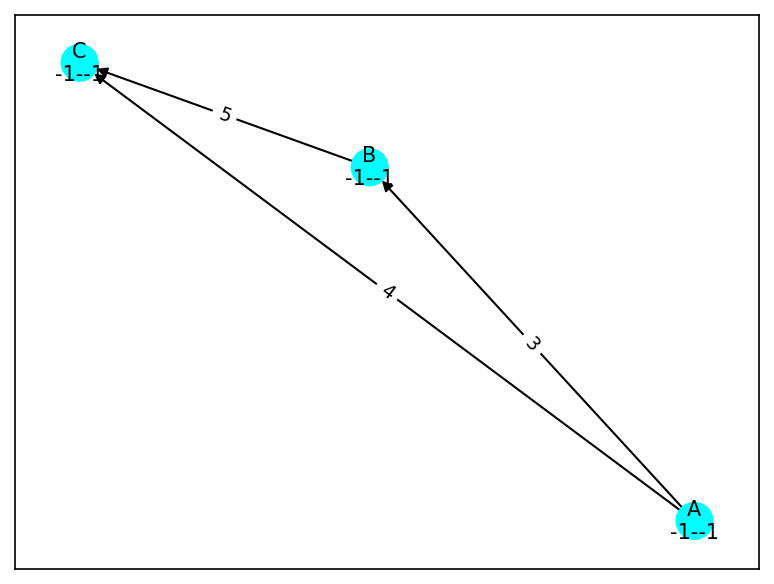

In [87]:
import random
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

class Thing:
    def __init__(self, name=''):
        self.name = name
    def __repr__(self):
        return self.name

class Problem(Thing):
    def __init__(self, name):
        super().__init__(name)

class Node(Thing):
    def __init__(self, name, children=None, loc=None, state=-1, order=-1):
        super().__init__(name)
        self.children = children if children is not None else {}
        self.loc = loc
        self.state = state
        self.order = order
    def add_child(self, child_name, child_weight):
        self.children[child_name] = child_weight

class Graph(Thing):
    def __init__(self, name):
        super().__init__(name)
        self.node_list = []
        self.node_map = {}
    def add_node(self, node):
        self.node_list.append(node)  # 如果我们希望node实际有一个位置属性，这里可变
        self.node_map[node.name] = node
    def draw(self, font_size=10, k_layout=0.1):
        plt.rcdefaults()
        plt.rcParams['figure.dpi'] = 150
        g = nx.DiGraph()
        # g = nx.Graph()
        edges = []
        edges_map = {}
        for node in self.node_list:
            for key, val in node.children.items():
                edges.append((node.name, key, 1 / val))
                edges_map[(node.name, key)] = val
        g.add_weighted_edges_from(edges)
        # {'':(x,y)}
        pos_map = {}
        nodes_label = {}
        for node in self.node_list:
            if node.loc is not None:
                pos_map[node.name] = node.loc
            nodes_label[node.name] = node.name +"\n"+str(node.state)+"-"+str(node.order)
        # print(pos_map)
        rand_seed = random.randint(1, 1000)
        if len(pos_map) > 0:
            locs = nx.spring_layout(g, pos=pos_map, fixed=pos_map.keys(), seed=rand_seed, k=k_layout)
        else:
            locs = nx.spring_layout(g, seed=rand_seed, k=k_layout)
        # print(locs)
        color_arr = []
        for node in self.node_list:
            color_arr.append(node.state)
        nx.draw_networkx_nodes(g, pos=locs,
                               node_color=color_arr,
                               cmap=plt.cm.cool)  #[ 1,2,3,4]
        nx.draw_networkx_labels(g, pos=locs,
                                labels=nodes_label, # {'Arad':"Arad\ncost-n"}
                                font_size=font_size,
                                font_color='black')

        nx.draw_networkx_edges(g, pos=locs, )
        nx.draw_networkx_edge_labels(g, pos=locs,
                                     edge_labels=edges_map,
                                     font_size=font_size - 1)  # {(start, end):1}

g = Graph('g')
g.add_node(Node('A', {'B': 3, 'C': 4}, (0, 0)))
g.add_node(Node('B', {'C': 5}))
g.add_node(Node('C', {}))
g.draw()


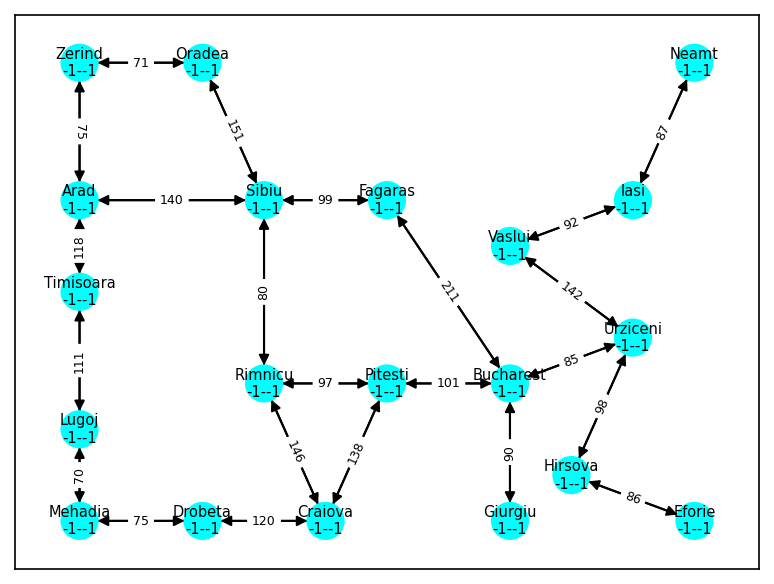

In [89]:
class RomaniaProblemGraph(Graph, Problem):
    def __init__(self, name):
        super().__init__(name)
        romania_nodes = pd.read_csv("data/romania_nodes.csv")
        # romania_nodes = pd.read_csv("data/romania_nodes_delete.csv")
        romania_edges = pd.read_csv("data/romania_edges.csv")
        for idx, (s, e, w) in romania_edges.iterrows():
            self.add_edge((s, e, w))
        for idx, (s, x, y) in romania_nodes.iterrows():
            if not np.isnan(x) or not np.isnan(y):
                self.node_map[s].loc = (x, y)
    def add_edge(self, edge):
        if edge[0] in self.node_map:
            node_0 = self.node_map[edge[0]]
        else:
            node_0 = Node(edge[0])
            self.add_node(node_0)
        if edge[1] in self.node_map:
            node_1 = self.node_map[edge[1]]
        else:
            node_1 = Node(edge[1])
            self.add_node(node_1)
        node_0.add_child(node_1.name, edge[2])
        node_1.add_child(node_0.name, edge[2])

problem = RomaniaProblemGraph('problem1')
problem.draw(font_size=7, k_layout=0.3)


Arad 0
Arad-Zerind 75
Arad-Sibiu 140
Arad-Timisoara 118
Arad-Zerind-Oradea 146
Arad-Sibiu-Fagaras 239
Arad-Sibiu-Rimnicu 220
Arad-Timisoara-Lugoj 229
Arad-Sibiu-Fagaras-Bucharest 450
Arad-Sibiu-Rimnicu-Pitesti 317
Arad-Sibiu-Rimnicu-Craiova 366
Arad-Timisoara-Lugoj-Mehadia 299
Arad-Sibiu-Fagaras-Bucharest-Urziceni 535
Arad-Sibiu-Fagaras-Bucharest-Giurgiu 540
Arad-Sibiu-Rimnicu-Craiova-Drobeta 486
Arad-Sibiu-Fagaras-Bucharest-Urziceni-Vaslui 677
Arad-Sibiu-Fagaras-Bucharest-Urziceni-Hirsova 633
Arad-Sibiu-Fagaras-Bucharest-Urziceni-Vaslui-Iasi 769
Arad-Sibiu-Fagaras-Bucharest-Urziceni-Hirsova-Eforie 719
Arad-Sibiu-Fagaras-Bucharest-Urziceni-Vaslui-Iasi-Neamt 856


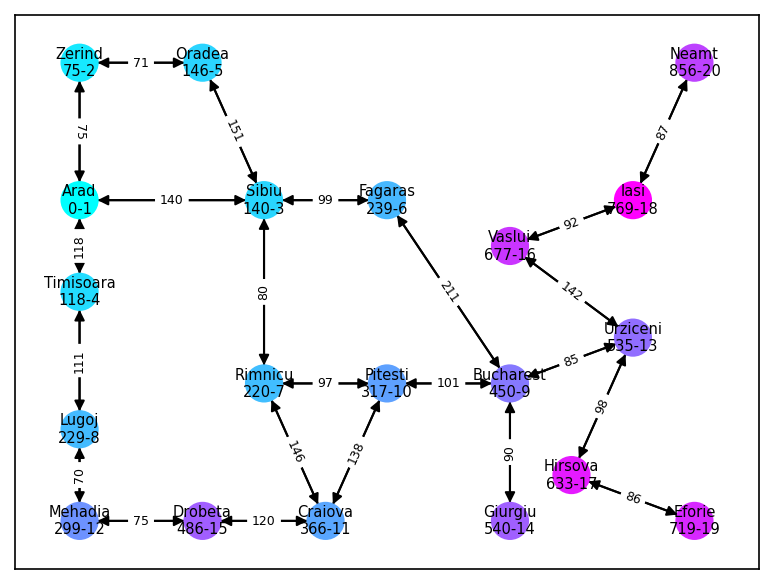

In [91]:
# 宽度优先
from collections import deque

problem = RomaniaProblemGraph("Bucharest")

unvisited_nodes = deque()

unvisited_nodes.append(problem.node_map['Arad'])

problem.node_map['Arad'].state=0
problem.node_map['Arad'].path="Arad"
order = 1
while len(unvisited_nodes)>0:
    visiting_node = unvisited_nodes.popleft()
    visiting_node.order = order
    order = order + 1
    for child_name, path_cost in visiting_node.children.items():
        child_node = problem.node_map[child_name]
        if child_node.state == -1:
            child_node.state = visiting_node.state + path_cost
            child_node.path = visiting_node.path + "-" + child_node.name
            unvisited_nodes.append(child_node)
    print(visiting_node.path, visiting_node.state)
problem.draw(font_size=7, k_layout=0.3)

Arad 0
Arad-Timisoara 118
Arad-Timisoara-Lugoj 229
Arad-Timisoara-Lugoj-Mehadia 299
Arad-Timisoara-Lugoj-Mehadia-Drobeta 374
Arad-Timisoara-Lugoj-Mehadia-Drobeta-Craiova 494
Arad-Timisoara-Lugoj-Mehadia-Drobeta-Craiova-Pitesti 632
Arad-Timisoara-Lugoj-Mehadia-Drobeta-Craiova-Pitesti-Bucharest 733
Arad-Timisoara-Lugoj-Mehadia-Drobeta-Craiova-Pitesti-Bucharest-Giurgiu 823
Arad-Timisoara-Lugoj-Mehadia-Drobeta-Craiova-Pitesti-Bucharest-Urziceni 818
Arad-Timisoara-Lugoj-Mehadia-Drobeta-Craiova-Pitesti-Bucharest-Urziceni-Hirsova 916
Arad-Timisoara-Lugoj-Mehadia-Drobeta-Craiova-Pitesti-Bucharest-Urziceni-Hirsova-Eforie 1002
Arad-Timisoara-Lugoj-Mehadia-Drobeta-Craiova-Pitesti-Bucharest-Urziceni-Vaslui 960
Arad-Timisoara-Lugoj-Mehadia-Drobeta-Craiova-Pitesti-Bucharest-Urziceni-Vaslui-Iasi 1052
Arad-Timisoara-Lugoj-Mehadia-Drobeta-Craiova-Pitesti-Bucharest-Urziceni-Vaslui-Iasi-Neamt 1139
Arad-Timisoara-Lugoj-Mehadia-Drobeta-Craiova-Pitesti-Bucharest-Fagaras 944
Arad-Timisoara-Lugoj-Mehadia-Drob

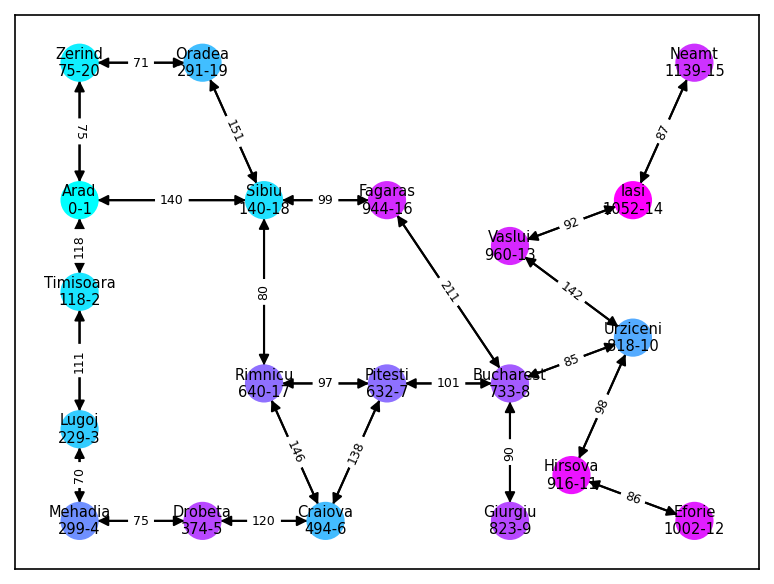

In [92]:
# 深度优先
from collections import deque

problem = RomaniaProblemGraph("Bucharest")

unvisited_nodes = deque()

unvisited_nodes.append(problem.node_map['Arad'])

problem.node_map['Arad'].state=0
problem.node_map['Arad'].path="Arad"
order = 1
while len(unvisited_nodes)>0:
    visiting_node = unvisited_nodes.pop()
    visiting_node.order = order
    order = order + 1
    for child_name, path_cost in visiting_node.children.items():
        child_node = problem.node_map[child_name]
        if child_node.state == -1:
            child_node.state = visiting_node.state + path_cost
            child_node.path = visiting_node.path + "-" + child_node.name
            unvisited_nodes.append(child_node)
    print(visiting_node.path, visiting_node.state)
problem.draw(font_size=7, k_layout=0.3)